In [1]:
from bs4 import BeautifulSoup
import os
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import numpy as np
import seaborn as sns

This code goes to the polito senate results page from the 2014 election and gets the url for every state that had an election that year. 

In [3]:
url = 'http://www.politico.com/2014-election/general/results/map/senate#.WAbEQ5MrKHo'

def get_hrefs(url):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text,'html')

    soup = soup.find('div', {'class': 'content-alpha'}) # find the main content of the page
    hrefs = []

    for s in soup.findAll('article', {'class': 'timeline-group'}): # for each state
        try:
            l = []
            l.append(s.find('header', {'class':'timeline-header'}).text.strip()) # get the state's name
            l.append(s.find(text='Detailed Results').parent.findParent('a')['href']) # get the state's url
            hrefs.append(l)
        except:
            print('error')


/Users/nickybangs/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /Users/nickybangs/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


error


Now that we have the urls, we go to each page and get the results for each county in the state. These results will be used to label each county as a Red or Blue county.   
  
Using Selenium because the content on these pages only load when activated by a scroll. 

In [ ]:
s_dict = make_dict(hrefs)

In [16]:
def make_dict(hrefs):
    chromedriver = "/Users/nickybangs/Code/chromedriver"  # start a new chromedriver
    os.environ["webdriver.chrome.driver"] = chromedriver

    driver = webdriver.Chrome(chromedriver)
    
    state_dict = {} # {state: {county: [results], county: ...}, state: ... } 

    for h in hrefs: # for each state
        url = h[1]
        driver.get(url)
        state = h[0] # state name stored here earlier, 
        state_dict[state] = {} # set it as key in dictionary pointing to another dictionary
        driver.execute_script("window.scrollTo(0,99999999999999);") # load all content
        sleep(20) # give the page time to load (10 seconds didn't allow all content to load for three states)
        data = driver.page_source # get the source html
        soup = BeautifulSoup(data,'html') # and turn it into a beautiful soup object

        soup = soup.find('div', {'class': 'content-alpha'}) # get to main content

        for s in soup.findAll('article', {'class': 'results-group'}): # for each county
            county = s.find('div', {'class':'title'}).text # get the county name
            state_dict[state][county] = [] # and set it as key of nested dictionary
            try:
                for r in s.find('table', {'class': 'results-table'}).findAll('tr'): # for each result (rep., dem., etc.)
                    l = []
                    l.append(r['class'][0].split('-')[1]) # get the political party 
                    try:
                        l.append(r.find('span', {'class':'number'}).text) # get the percentage of the vote
                        l.append(r.find('td', {'class':'results-popular'}).text) # get the number of votes
                    except:
                        l.append(r.find('td', {'class':'results-exception'}).text) # in this case it was uncontested 
                    state_dict[state][county].append(l)
            except:
                print(state)
    return state_dict

Sometimes this will miss certain counties, if it does, it will print out the state's name where a county was missed (an error occurs when trying to access county data which hasn't loaded).
In this case the states were Texas and South Carolina, so we have to rerun the function on these states and update the dictionary. 

In [11]:
nrefs = [h for h in hrefs if h[0] in ['Texas','South Carolina']]
d = make_dict(nrefs)

In [21]:
del s_dict['Texas']
del s_dict['South Carolina']
s_dict['Texas'] = d['Texas']
s_dict['South Carolina'] = d['South Carolina']

Instead of using a dictionary, turn the whole thing into a matrix of lists whose elements are [state, county, results], this is then turned into a dataframe.

In [22]:
m = []
for state in state_dict:
    for county in state_dict[state]:
        m.append([state,county,state_dict[state][county]])

In [23]:
df = pd.DataFrame(m)

df.columns = ['state','county','politics']

Here's what our dataframe looks like so far:

In [24]:
df.head()

,state,county,politics
0,Colorado,Grand County,"[[republican, 53.6%, 3,616], [democrat, 41.0%,..."
1,Colorado,Rio Blanco County,"[[republican, 81.4%, 2,207], [democrat, 13.2%,..."
2,Colorado,Conejos County,"[[republican, 47.9%, 1,659], [democrat, 46.7%,..."
3,Colorado,Custer County,"[[republican, 65.9%, 1,654], [democrat, 29.5%,..."
4,Colorado,Baca County,"[[republican, 73.9%, 1,373], [democrat, 19.0%,..."


This function finds the party with the highest percentage in a county. It expects a list of size >= 1 containing the nested lists of the results for the election.

In [25]:
def find_max(l):
    if len(l) == 1:
        return l[0][0]
    percentages = [float(subl[1].strip('%')) for subl in l]
    i = percentages.index(max(percentages))
    return l[i][0]

This is needed to make sure the code below gets all the counties in all the states. 

In [27]:
df.ix[(df['state']=='Texas') & (df['county']=='De Witt County'),'county'] = 'DeWitt County'
df.ix[(df['state']=='Texas') & (df['county']=='La Vaca County'),'county'] = 'Lavaca County'
df.ix[(df['state']=='Illinois') & (df['county']=='DeWitt County'),'county'] = 'De Witt County'
df.ix[(df['state']=='Illinois') & (df['county']=='LaSalle County'),'county'] = 'La Salle County'
df.ix[(df['state']=='Illinois') & (df['county']=='JoDaviess County'),'county'] = 'Jo Daviess County'
df.ix[(df['state']=='New Mexico') & (df['county']=='DeBaca County'),'county'] = 'De Baca County'
df.ix[(df['state']=='Mississippi') & (df['county']=='Jeff Davis County'),'county'] = 'Jefferson Davis County'
df.ix[(df['state']=='Idaho') & (df['county']=='Idaho County County'),'county'] = 'Idaho County'
df.ix[(df['state']=='Arkansas') & (df['county']=='Saint Francis County'),'county'] = 'St. Francis County'
df.ix[(df['state']=='Minnesota') & (df['county']=='Lac Qui Parle County'),'county'] = 'Lac qui Parle County'
df.ix[(df['state']=='Oklahoma') & (df['county']=='LeFlore County'),'county'] = 'Le Flore County'
df.ix[(df['state']=='Louisiana') & (df['county']=='LaSalle Parish'),'county'] = 'La Salle Parish'
df.ix[(df['state']=='Louisiana') & (df['county']=='DeSoto Parish'),'county'] = 'De Soto Parish'
df.ix[(df['state']=='Louisiana') & (df['county']=='Jeff Davis Parish'),'county'] = 'Jefferson Davis Parish'
df.ix[(df['state']=='Kentucky') & (df['county']=='LaRue County'),'county'] = 'Larue County'
#df.ix[(df['state']=='Virginia') & (df['county']=='Bedford County'),'county'] = 'Bedford City County'

Create a new column 'color' which contains the party with the highest percentage. 

In [28]:
df['color'] = df['politics'].apply(find_max)

Just to be safe, let's get this into a csv file. 

In [ ]:
df.to_csv('2014_senate_counties.csv')

Now that we have each states political tendency, we can fill in a map of the US at the county level, coloring each county red, blue or green.

/Users/nickybangs/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Virginia Bedford City


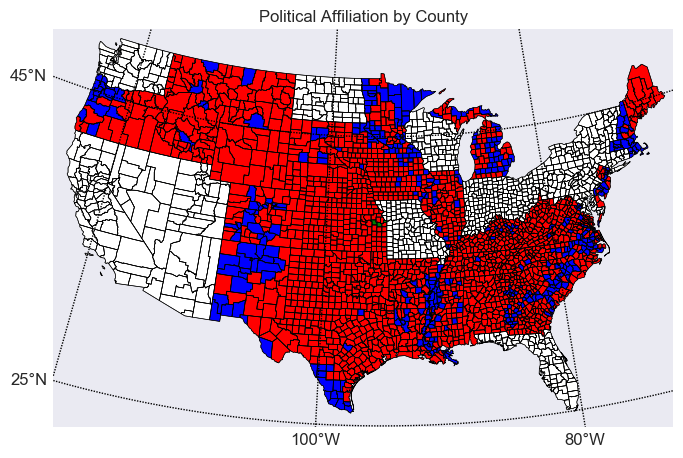

In [29]:
color_dict = {'republican': 'red', 'democrat': 'blue', 'independent': 'green'}

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# lat_1,2 - lon_0 -- center

# county shapefile
shp_info = m.readshapefile('/Users/nickybangs/ds/metis/mcnulty/data/2016-us-election/county_shapefiles/UScounties','counties',drawbounds=True)

countynames = []

for shapedict in m.counties_info:
    try:
        countynames.append([shapedict['STATE_NAME'],shapedict['NAME']])
    except:
        pass

ax = plt.gca()

for nshape,seg in enumerate(m.counties):
    try:
        if countynames[nshape][0] == 'Louisiana':
            appenda = 'Parish'
        else:
            appenda = 'County'
        c = df[df['state']==countynames[nshape][0]][df['county']==str('{} {}'.format(countynames[nshape][1],appenda))]
        if len(c) > 0:
            col = color_dict[c['color'].iloc[0]]
        else:
            if len(df[df['state']==countynames[nshape][0]]) > 0 and countynames[nshape][0] not in ['Alaska','Hawaii']: 
                print(countynames[nshape][0],countynames[nshape][1])
            col = 'white'
        poly = Polygon(seg,facecolor=col,edgecolor='black')
        ax.add_patch(poly)
    except:
        poly = Polygon(seg,facecolor='w',edgecolor='black')
        ax.add_patch(poly)
# draw meridians and parallels.
m.drawparallels(np.arange(25,65,20),labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,-40,20),labels=[0,0,0,1])
plt.title('Political Affiliation by County')
plt.show()

Okay! We have some county level political data for a good portion of the country. Now we need to get the other states. Back to Politico! 

In [ ]:
url = 'http://www.politico.com/2012-election/results/map/#/Senate/2012/'